In [1]:
!pip install wget
!pip install Sastrawi
!pip install nlp_id

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import os
import pickle
import warnings
import wget
import sklearn
import random
import nltk
import spacy
import textblob
import gensim
from gensim.models import Word2Vec
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, SimpleRNN
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing import sequence
# from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from nltk.corpus import stopwords
from nltk.tree import Tree
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from collections import Counter, OrderedDict
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from spacy.util import minibatch, compounding
from spacy import load, displacy
from spacy.training.example import Example
from nlp_id import stopword
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('./sample_data/tweet.csv')

In [4]:
df.head()

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [5]:
df.tail()

,Unnamed: 0,sentimen,tweet
1810,1810,netral,Negarawan sejati sll bangga dan mengedepankan ...
1811,1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...
1813,1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...
1814,1814,netral,Pak @jokowi mengubah cara pandang ekonomi. Kin...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [7]:
df.isnull().sum()

Unnamed: 0    0
sentimen      0
tweet         0
dtype: int64

## Case Folding

In [8]:
df['tweet'] = df['tweet'].str.lower()

In [9]:
df.tweet

0       kata @prabowo indonesia tidak dihargai bangsa ...
1       batuan langka, tasbih jokowi hadiah dari habib...
2       di era jokowi, ekonomi indonesia semakin baik....
3       bagi sumatera selatan, asian games berdampak p...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811    1. hrs ceramah di damai indonesiaku 2. perekon...
1812    mari bangun bangsa dgn mendukung perekonomian ...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak @jokowi mengubah cara pandang ekonomi. kin...
Name: tweet, Length: 1815, dtype: object

## Tokenization

In [10]:
df['tweet'] = [nltk.word_tokenize(tweets) for tweets in df['tweet']]

for token in df['tweet']:
    print(token)

['kata', '@', 'prabowo', 'indonesia', 'tidak', 'dihargai', 'bangsa', 'asing', '!', 'berita', 'ini', 'ðÿ', '‘', '‡', 'pasti', 'hoax', 'buatan', 'penguasa', ',', 'ya', 'kan', '@', 'rockygerung', '?', 'ðÿ˜œ', 'https', ':', '//twitter.com/mediaindonesia/status/1117575436337160192', '?', 's=21â', 'â€¦']
['batuan', 'langka', ',', 'tasbih', 'jokowi', 'hadiah', 'dari', 'habib', 'luthfi', 'seharga', 'mercy', '?', 'http', ':', '//dlvr.it/r2pvzvâ']
['di', 'era', 'jokowi', ',', 'ekonomi', 'indonesia', 'semakin', 'baik', '.', '#', '01indonesiamaju', '#', 'jokowilagi', '#', 'jokowimenangtotaldebat', 'pic.twitter.com/w2ythnxstp']
['bagi', 'sumatera', 'selatan', ',', 'asian', 'games', 'berdampak', 'pd', 'ekonomi', 'langsung', 'diprediksi', 'mencapai', '18,5', 'triliun', '.', 'indonesia', 'maju', ',', 'jokowi', 'hebat', '!']
['negara', 'kita', 'ngutang', 'buat', 'bngun', 'infrastruktur', 'yang', 'udah', 'dipake', 'masyarakat', ',', 'terus', 'masyarakatnya', 'ngeluh', 'karena', 'negara', 'ngutang', ',',

In [11]:
df['tweet']

0       [kata, @, prabowo, indonesia, tidak, dihargai,...
1       [batuan, langka, ,, tasbih, jokowi, hadiah, da...
2       [di, era, jokowi, ,, ekonomi, indonesia, semak...
3       [bagi, sumatera, selatan, ,, asian, games, ber...
4       [negara, kita, ngutang, buat, bngun, infrastru...
                              ...                        
1810    [negarawan, sejati, sll, bangga, dan, mengedep...
1811    [1., hrs, ceramah, di, damai, indonesiaku, 2.,...
1812    [mari, bangun, bangsa, dgn, mendukung, perekon...
1813    [bantu, majukan, perekonomian, bangsa, bersama...
1814    [pak, @, jokowi, mengubah, cara, pandang, ekon...
Name: tweet, Length: 1815, dtype: object

## Cleaning

### Stopword Removal

In [12]:
stop_words = set(stopwords.words('indonesian'))

# df['tweet'] = df['tweet'].apply(lambda x: [word for word in df['tweet'] if word not in stop_words])

# df['tweet']

# Assuming 'tweet' is a column in your DataFrame 'df'
df['tweet'] = df['tweet'].apply(lambda x: [word for word in x if word not in stopwords.words('indonesian')])

# Print the updated column
print(df['tweet'])

0       [@, prabowo, indonesia, dihargai, bangsa, asin...
1       [batuan, langka, ,, tasbih, jokowi, hadiah, ha...
2       [era, jokowi, ,, ekonomi, indonesia, ., #, 01i...
3       [sumatera, selatan, ,, asian, games, berdampak...
4       [negara, ngutang, bngun, infrastruktur, udah, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, mengedepankan...
1811    [1., hrs, ceramah, damai, indonesiaku, 2., per...
1812    [mari, bangun, bangsa, dgn, mendukung, perekon...
1813    [bantu, majukan, perekonomian, bangsa, jokowi,...
1814    [@, jokowi, mengubah, pandang, ekonomi, ., ora...
Name: tweet, Length: 1815, dtype: object


### Punctuation

In [13]:
df['tweet'] = df['tweet'].apply(lambda x: [re.sub(r'[^\w\s]', '', word) for word in x])

df['tweet']

0       [, prabowo, indonesia, dihargai, bangsa, asing...
1       [batuan, langka, , tasbih, jokowi, hadiah, hab...
2       [era, jokowi, , ekonomi, indonesia, , , 01indo...
3       [sumatera, selatan, , asian, games, berdampak,...
4       [negara, ngutang, bngun, infrastruktur, udah, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, mengedepankan...
1811    [1, hrs, ceramah, damai, indonesiaku, 2, perek...
1812    [mari, bangun, bangsa, dgn, mendukung, perekon...
1813    [bantu, majukan, perekonomian, bangsa, jokowi,...
1814    [, jokowi, mengubah, pandang, ekonomi, , orang...
Name: tweet, Length: 1815, dtype: object

In [14]:
df['tweet'][:2]

0    [, prabowo, indonesia, dihargai, bangsa, asing...
1    [batuan, langka, , tasbih, jokowi, hadiah, hab...
Name: tweet, dtype: object

In [15]:
df['tweet'] = df['tweet'].apply(lambda x : [word for word in x if word != ''])

df['tweet']

0       [prabowo, indonesia, dihargai, bangsa, asing, ...
1       [batuan, langka, tasbih, jokowi, hadiah, habib...
2       [era, jokowi, ekonomi, indonesia, 01indonesiam...
3       [sumatera, selatan, asian, games, berdampak, p...
4       [negara, ngutang, bngun, infrastruktur, udah, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, mengedepankan...
1811    [1, hrs, ceramah, damai, indonesiaku, 2, perek...
1812    [mari, bangun, bangsa, dgn, mendukung, perekon...
1813    [bantu, majukan, perekonomian, bangsa, jokowi,...
1814    [jokowi, mengubah, pandang, ekonomi, orang, te...
Name: tweet, Length: 1815, dtype: object

## Stemming

In [16]:
stemmer = StemmerFactory().create_stemmer()

df['tweet'] = df['tweet'].apply(lambda x: [stemmer.stem(word) for word in x])

df['tweet']

0       [prabowo, indonesia, harga, bangsa, asing, ber...
1       [batu, langka, tasbih, jokowi, hadiah, habib, ...
2       [era, jokowi, ekonomi, indonesia, 01indonesiam...
3       [sumatera, selatan, asi, games, dampak, pd, ek...
4       [negara, ngutang, bngun, infrastruktur, udah, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, depan, harga,...
1811    [1, hrs, ceramah, damai, indonesia, 2, ekonomi...
1812    [mari, bangun, bangsa, dgn, dukung, ekonomi, n...
1813    [bantu, maju, ekonomi, bangsa, jokowi, yuk, ht...
1814    [jokowi, ubah, pandang, ekonomi, orang, hubung...
Name: tweet, Length: 1815, dtype: object

In [17]:
display(df['tweet'][:1])

0    [prabowo, indonesia, harga, bangsa, asing, ber...
Name: tweet, dtype: object

In [18]:
# from nltk.stem import WordNetLemmatizer

# lemmatizer = WordNetLemmatizer()
# df['tweet'] = df['tweet'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# display(df['tweet'])

In [19]:
tweet_words_flattened = list(itertools.chain(*df['tweet']))
tweet_words_count = Counter(tweet_words_flattened)
tweet_words_count_sorted = OrderedDict(sorted(tweet_words_count.items(), key = lambda kv : kv[1], reverse=False))

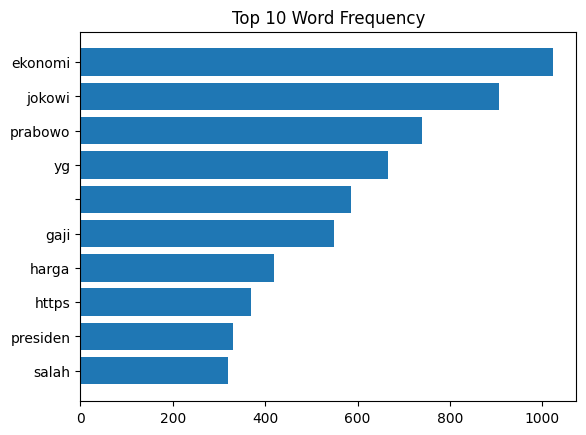

In [20]:
plt.barh(
    list(tweet_words_count_sorted.keys())[-10:],
    list(tweet_words_count_sorted.values())[-10:]
)

plt.title('Top 10 Word Frequency')
plt.show()